Cell 1: Load libraries and dataset from S3

In [1]:
# Cell 1: Load libraries and dataset from S3

import boto3        # import boto3 to connect to AWS S3
import pandas as pd # import pandas for data handling

bucket = "ai-bmi-predictor"                 # name of the S3 bucket
key = "test-data/eff_testingB.csv"         # path to the CSV file inside the bucket

s3 = boto3.client("s3")                    # create an S3 client using your AWS credentials
obj = s3.get_object(Bucket=bucket, Key=key)  # download the S3 object that contains the CSV file

data = pd.read_csv(obj["Body"])           # read the CSV content from the S3 object body into a DataFrame

data.head()                               # display the first few rows to confirm the data loaded correctly


,photo_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist,gender,height_cm,weight_kg
0,5e09e1b0d43b6c430709a513f594c591,0.109534,-0.016982,-0.146092,0.516881,0.189749,-0.067232,-0.048589,-0.022137,0.045580,...,91.273094,77.553963,36.633358,64.253914,47.014259,77.113548,16.389431,male,170.00,61.8
1,7e6a57e2fcabf518e9007a77d4cc4960,0.094942,0.000988,-0.126504,0.834527,0.315265,0.002205,-0.067837,-0.093690,-0.021319,...,91.707520,76.172325,34.205143,61.726360,48.404037,73.617821,14.480244,female,169.00,54.5
2,4ee8251ae7e4ad42c75644db390fc5c5,-0.032353,-0.051524,-0.129219,0.430257,0.209280,-0.131291,0.039772,-0.062221,0.072620,...,89.962387,74.400047,31.023907,56.728245,47.468864,72.155304,15.670779,female,164.59,52.1
3,6367d327f96b951e4a498c88d615e8a4,0.056546,0.007736,-0.147426,0.731932,0.264191,-0.050348,-0.145324,-0.088448,-0.021515,...,96.964554,76.552322,36.380489,63.264416,47.635548,82.428825,16.714935,male,168.00,67.4
4,8b16daea6768b92fb27997f76215aa5f,0.004628,-0.047994,-0.155691,0.587151,0.235884,-0.101305,-0.065924,-0.134367,0.021547,...,115.346634,85.163284,39.959301,72.723900,61.206940,115.251938,19.627054,male,184.30,111.3


Cell 2: Compute BMI

In [2]:
# Cell 2: Compute BMI (using original height and weight) and store it in the dataset

data["BMI"] = data["weight_kg"] / ((data["height_cm"] / 100) ** 2)  # calculate BMI and save as a new column
data["BMI"].describe()                                              # quickly inspect BMI statistics

count    1160.000000
mean       25.320349
std         5.756564
min        15.672380
25%        21.453646
50%        24.105602
75%        27.314484
max        48.009785
Name: BMI, dtype: float64

Cell 3: Categorical encoding for 'gender' feature

In [3]:
# Cell 3: Categorical encoding for 'gender' feature

data["gender"] = data["gender"].astype("category")  # convert 'gender' column to categorical type
data["gender"] = data["gender"].cat.codes           # replace categories with numeric codes

Cell 4: apply stnadard sclaer for body measurements and robust scaler for cnn extracted features

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# -----------------------------
# 1. Columns
# -----------------------------

# columns to exclude from any scaling
exclude_cols = ['photo_id', 'subject_id', 'index', 'gender','BMI']

# target columns (predicted outputs)
target_cols = [
    'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip',
    'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh',
    'waist', 'wrist', 'weight_kg'
]

# feature columns that must use StandardScaler (but are NOT targets)
standard_feature_cols = ['height_cm']

# keep only existing columns
target_cols = [c for c in target_cols if c in data.columns]
standard_feature_cols = [c for c in standard_feature_cols if c in data.columns]

# remaining feature columns → RobustScaler
robust_feature_cols = [
    col for col in data.columns
    if col not in exclude_cols
    and col not in target_cols
    and col not in standard_feature_cols
]

# -----------------------------
# 2. Create scalers
# -----------------------------

scaler_targets = StandardScaler()           # for inverse scaling
scaler_standard_features = StandardScaler()
scaler_robust_features = RobustScaler()

# -----------------------------
# 3. Fit & transform
# -----------------------------

data[target_cols] = scaler_targets.fit_transform(data[target_cols])
data[standard_feature_cols] = scaler_standard_features.fit_transform(
    data[standard_feature_cols]
)
data[robust_feature_cols] = scaler_robust_features.fit_transform(
    data[robust_feature_cols]
)


Cell 5: Create X (independent features) and Y (multi-target outputs)

In [5]:
# Cell 5: Create X (independent features) and Y (multi-target outputs)

target_cols = [
    "ankle", "arm-length", "bicep", "calf", "chest", "forearm", "hip",
    "leg-length", "shoulder-breadth", "shoulder-to-crotch", "thigh",
    "waist", "wrist", "weight_kg"
]                                                # list of target columns for multi-target regression

Y = data[target_cols]                            # select target columns as Y (scaled values)
print("Selected target columns:", target_cols)   # print which columns are used as targets
print("Shape of Y (samples, targets):", Y.shape) # print the shape of Y to confirm dimensions

drop_cols = ["photo_id", "subject_id"] + target_cols + ["BMI"]  # columns to drop when building X (IDs, targets, BMI helper column)

print("Columns to drop for X:\n", drop_cols)     # show which columns will be removed from data to form X

X = data.drop(columns=drop_cols)                 # drop unwanted columns to create feature matrix X

print("\nShape of X (samples, independent features):", X.shape)  # print shape of X
# print("\nColumns in X:\n", X.columns.tolist())   # optional: print all feature names in X


Selected target columns: ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist', 'weight_kg']
Shape of Y (samples, targets): (1160, 14)
Columns to drop for X:
 ['photo_id', 'subject_id', 'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist', 'weight_kg', 'BMI']

Shape of X (samples, independent features): (1160, 5122)


Cell 6: Load trained Keras model from S3

In [6]:
# Cell 6: Load trained Keras model from S3 (in-memory)

In [7]:


import io                                        # import io for in-memory byte streams
import h5py                                      # import h5py to open HDF5 file objects
import tensorflow as tf                          # import tensorflow to load the Keras model

bucket_name = "ai-bmi-predictor"                 # S3 bucket name for the trained model
model_key  = "trained-models/efficientnet-models/eff_ann_version8.h5"  # path of model file in S3

print("Creating S3 client...")                   # status message to show progress
s3 = boto3.client("s3")                          # create a new S3 client (safe even if one already exists)

print(f"Reading model bytes from s3://{bucket_name}/{model_key}")  # show which model file is being read
obj = s3.get_object(Bucket=bucket_name, Key=model_key)             # download the model file as an S3 object
model_bytes = obj["Body"].read()                                   # read the S3 object body as raw bytes

byte_stream = io.BytesIO(model_bytes)           # wrap the raw bytes in an in-memory binary stream

print("Opening HDF5 file from memory...")        # status message before loading HDF5
with h5py.File(byte_stream, "r") as h5file:      # open the binary stream as an HDF5 file
    best_model = tf.keras.models.load_model(h5file)  # load the Keras model from the HDF5 file

print("Model loaded successfully from S3 (in-memory)!")  # confirmation message


2025-12-16 15:14:07.360479: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 15:14:07.374864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-16 15:14:07.399338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-16 15:14:07.399363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-16 15:14:07.414300: I tensorflow/core/platform/cpu_feature_gua

Creating S3 client...
Reading model bytes from s3://ai-bmi-predictor/trained-models/efficientnet-models/eff_ann_version8.h5
Opening HDF5 file from memory...
Model loaded successfully from S3 (in-memory)!


2025-12-16 15:14:09.293102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-16 15:14:09.339245: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-16 15:14:09.340275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
data['BMI'].head()

0    21.384083
1    19.081965
2    19.232283
3    23.880385
4    32.767589
Name: BMI, dtype: float64

Cell 7: Pick one random record within a BMI range, predict targets, and compare with actual values

In [9]:
# Cell 7: Pick one random record within a BMI range, predict targets, and compare with actual values

bmi_min = 25.0                                    # minimum BMI value for selection
bmi_max = 30.0                                    # maximum BMI value for selection

bmi_filtered = data[(data["BMI"] >= bmi_min) &    # filter rows where BMI is greater than or equal to bmi_min
                    (data["BMI"] <= bmi_max)]     # and BMI is less than or equal to bmi_max

print("Number of records in BMI range:", len(bmi_filtered))  # show how many records match the BMI condition

if bmi_filtered.empty:                            # check if there are no rows in the requested BMI range
    raise ValueError("No records found in the BMI range 18–20. Please adjust the range or check the data.")  # raise an error if none

sample_row = bmi_filtered.sample(n=1, random_state=None)  # randomly pick a single row from the filtered DataFrame

sample_index = sample_row.index[0]               # get the index of the selected row

X_sample = X.loc[[sample_index]]                 # extract the corresponding feature row from X (as a DataFrame)
Y_sample_scaled = Y.loc[[sample_index]]          # extract the corresponding scaled targets row from Y

y_pred_scaled = best_model.predict(X_sample)     # use the trained model to predict scaled target values for the selected record

y_actual = scaler_targets.inverse_transform(     # inverse-transform scaled actual targets back to original units
    Y_sample_scaled.values
)

y_pred = scaler_targets.inverse_transform(       # inverse-transform scaled predicted targets back to original units
    y_pred_scaled
)

actual_df = pd.DataFrame(y_actual, columns=target_cols).T   # create a DataFrame for actual values (transpose for nicer layout)
actual_df.columns = ["Actual"]                              # rename the single column to 'Actual'

pred_df = pd.DataFrame(y_pred, columns=target_cols).T       # create a DataFrame for predicted values (transpose for nicer layout)
pred_df.columns = ["Predicted"]                             # rename the single column to 'Predicted'

result_df = pd.concat([actual_df, pred_df], axis=1)         # combine actual and predicted values side-by-side

print(f"Selected sample index: {sample_index}")             # show the index of the selected sample
print(f"BMI of selected sample: {data.loc[sample_index, 'BMI']:.2f}")  # print the BMI of the selected record
print("\nActual vs Predicted values for the selected record:\n")      # header for clarity
print(result_df)                                             # print the table with actual and predicted values


Number of records in BMI range: 267
1/1 [==============================] - 5s 5s/step
Selected sample index: 146
BMI of selected sample: 27.99

Actual vs Predicted values for the selected record:

                        Actual   Predicted
ankle                22.789526   22.700710
arm-length           43.790398   45.517902
bicep                30.687698   31.070229
calf                 37.041306   36.148254
chest               102.359299  105.210709
forearm              24.910326   24.034483
hip                 106.529602  103.271156
leg-length           67.613556   70.703392
shoulder-breadth     32.644356   31.930679
shoulder-to-crotch   58.855564   56.344528
thigh                52.522884   53.661858
waist                87.720589   88.275459
wrist                15.173304   15.446571
weight_kg            61.800000   66.792984


Step 8: Actual BMI vs Predicted BMI

In [10]:
# Cell 8: Actual BMI vs Predicted BMI

# -----------------------------
# Actual BMI
# -----------------------------

# get actual BMI directly from dataset (already computed earlier)
actual_bmi = data.loc[sample_index, "BMI"]

# -----------------------------
# Predicted BMI
# -----------------------------

# extract predicted weight from model output (inverse-scaled)
predicted_weight = y_pred[0, target_cols.index("weight_kg")]

# recover original height (inverse scale StandardScaler)
height_scaled = X_sample["height_cm"].values.reshape(-1, 1)
height_cm = scaler_standard_features.inverse_transform(height_scaled)[0, 0]

# compute predicted BMI using BMI formula
predicted_bmi = predicted_weight / ((height_cm / 100) ** 2)

# -----------------------------
# Display results
# -----------------------------

print("Actual BMI:", round(actual_bmi, 2))
print("Predicted BMI:", round(predicted_bmi, 2))


Actual BMI: 27.99
Predicted BMI: 30.25


Step 9: Actual BVI vs Predicted BVI

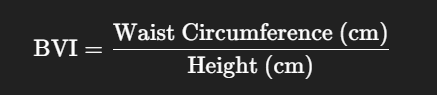

In [11]:
# Cell 9: Actual BVI vs Predicted BVI

# -----------------------------
# Actual BVI
# -----------------------------

# extract actual waist (inverse-scaled)
actual_waist = y_actual[0, target_cols.index("waist")]

# compute actual BVI
actual_bvi = actual_waist / height_cm

# -----------------------------
# Predicted BVI
# -----------------------------

# extract predicted waist from model output
predicted_waist = y_pred[0, target_cols.index("waist")]

# compute predicted BVI
predicted_bvi = predicted_waist / height_cm

# -----------------------------
# Display results
# -----------------------------

print("Actual BVI:", round(actual_bvi, 4))
print("Predicted BVI:", round(predicted_bvi, 4))


Actual BVI: 0.5903
Predicted BVI: 0.594


Step 10: Actual vs Predicted Body Fat Percentage

since we doesn't have 'age' as a feature, we have to use the following formula

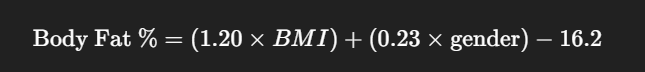

In [12]:
# Cell 10: Actual vs Predicted Body Fat Percentage (no age required)

# -----------------------------
# Gender
# -----------------------------

# extract gender from dataset (already encoded: male=1, female=0)
gender = data.loc[sample_index, "gender"]

# -----------------------------
# Actual Body Fat %
# -----------------------------

# compute actual body fat percentage using BMI-based formula
actual_body_fat = (
    1.20 * actual_bmi +
    0.23 * gender -
    16.2
)

# -----------------------------
# Predicted Body Fat %
# -----------------------------

# compute predicted body fat percentage using predicted BMI
predicted_body_fat = (
    1.20 * predicted_bmi +
    0.23 * gender -
    16.2
)

# -----------------------------
# Display results
# -----------------------------

print("Actual Body Fat %:", round(actual_body_fat, 2))
print("Predicted Body Fat %:", round(predicted_body_fat, 2))


Actual Body Fat %: 17.38
Predicted Body Fat %: 20.1


Step 12 : Fornt and Side image relted to the random selected record

In [13]:
# Cell 11: Print photo_id for selected sample

# extract photo_id of the selected sample
photo_id = data.loc[sample_index, "photo_id"]

# print photo_id
print("Selected photo_id:", photo_id)


Selected photo_id: d9539237b7aab0bca363d485ef056435


In [14]:
# Cell 12: Define S3 paths for front and side masks

# S3 bucket where body mask images are stored
image_bucket = "amazon-bodym"

# S3 key for front mask image
front_mask_key = f"testB/mask/{photo_id}.png"

# S3 key for side (left) mask image
side_mask_key = f"testB/mask_left/{photo_id}.png"

# print paths for confirmation
print("Front mask S3 path:", front_mask_key)
print("Side mask S3 path:", side_mask_key)


Front mask S3 path: testB/mask/d9539237b7aab0bca363d485ef056435.png
Side mask S3 path: testB/mask_left/d9539237b7aab0bca363d485ef056435.png


In [15]:
# Cell 13: Load front and side mask images from S3

from PIL import Image      # image handling
import matplotlib.pyplot as plt
import io                  # in-memory byte stream

# reuse existing S3 client or create a new one
s3 = boto3.client("s3")

# -----------------------------
# Load front mask image
# -----------------------------
front_obj = s3.get_object(Bucket=image_bucket, Key=front_mask_key)
front_img = Image.open(io.BytesIO(front_obj["Body"].read()))

# -----------------------------
# Load side mask image
# -----------------------------
side_obj = s3.get_object(Bucket=image_bucket, Key=side_mask_key)
side_img = Image.open(io.BytesIO(side_obj["Body"].read()))


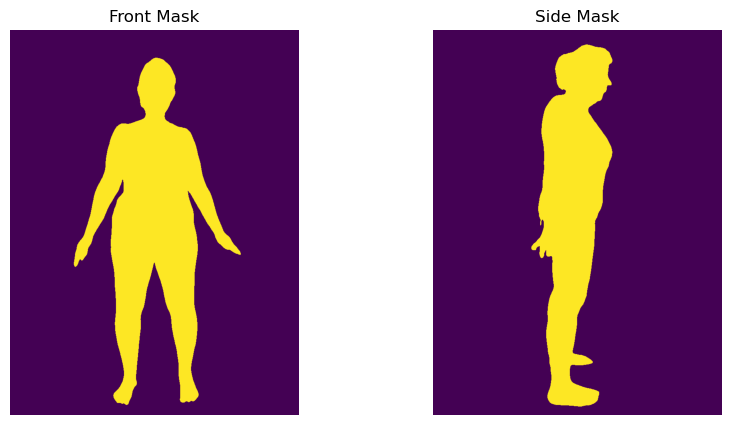

In [16]:
# Cell 14: Display front and side mask images

plt.figure(figsize=(10, 5))

# -----------------------------
# Front mask
# -----------------------------
plt.subplot(1, 2, 1)
plt.imshow(front_img)
plt.title("Front Mask")
plt.axis("off")

# -----------------------------
# Side mask
# -----------------------------
plt.subplot(1, 2, 2)
plt.imshow(side_img)
plt.title("Side Mask")
plt.axis("off")

plt.show()
